In [1]:
# 전이학습에 대해서 알아보아요!
# 당연히 전이학습을 하려면 pretrained Network이 있어야해요!
# 이미 누군가에 의해서 만들어진(학습된) CNN 모델이 있어야해요!
# 이런 Pretrained Network는 그 종류가 상당히 많아요!
# 그 중 대표적인 모델은 BGG16, VGG19(학습용), MS의 Resnet, Goolge의 Inception
# mobilenet(모델의 정확도는 낮지만 속도가 빠르고 가벼워요), EfficientNet(성능이 좋아요)
# 별의 별... model들이 있어요!

# Pretrained Network(CNN) 모델에서 우리가 사용할 수 있는 부분은
# 특징 추출부분이에요! 이 부분을 통해서 개와 고양이의 특징을 추출하고
# 머신러닝ㅇ서 배운 학습기(classfier)를 이용해서 머신러닝을 구현하면 되요!

# 결국 우리가 재사용하는 layer는 Conv2D, MaxPooling2D에요!
# Conv2D가 여러개 있을거고 MaxPooling2D도 여러개 있겠죠.
# 하위 Convolution Layer는 입력데이터의 국소적인 특징을 추출(질감, 선의 형태)
# 상위 Convolution Layer는 입력데이터의 형태적인 특징을 추출(눈, 코 등)

# 원래 다른 이미지(imagenet과 같은)로 만든 filter지만 우리의 개와 고양이의 특징을
# 추출하는데도 잘 사용할 수 있어요! => 그래서 가져다 쓰는데 문제가 없어요!

In [3]:
# VGG16은 tensorflow keras안에서 제공되요.
# 진짜 모델이 keras안에 포함된건 아니구요.
# keras를 이용하면 쉽게 다운로드 받을 수 있어요!
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                  include_top=False, # 특징만 추출하고 분류기는 직접 구현해야 해요!
                  input_shape=(150,150,3))

model_base.summary()

58889256/58889256 [==============================] - 9s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                              

In [ ]:
# 우리의 데이터를 model_base에 통과시켜서 그 결과인
# feature map을 ndarray에 저장할거에요!

# 그런 다음에 이 ndarray를 이용해서 classifier에 입력으로 넣어서 학습할거에요!
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16

model_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(150,150,3))

base_dir='./data/cat_dog_small'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

data_gen = ImageDataGenerator(rescale=1/255)
batch_size = 20

# 특정 폴더안에서 이미지 파일을 읽어서
# 해당 이미지의 픽셀을 추출해서 return하는게 아니라
# 이 이미지의 특징을 뽑고 그 특징 이미지의 픽셀데이터를 return하는 함수
def extract_feature(directory, sample_count):
    # 입력이미지의 특징을 추출해서 ndarray로 return
    features = np.zeros(shape=(sample_count, 4, 4, 512)) # VGG16에서 추출한 특징의 shape
    labels = np.zeros(shape=(sample_count,))

    generator = data_gen.flow_from_directory(
        directory,
        classes=['cats', 'dogs'],
        target_size=(150,150),
        batch_size=batch_size,
        class_mode='binary'
    )

    i = 0
    for x_data_batch, t_data_batch in generator:
        feature_batch = model_base.predict(x_data_batch)
        features[i * batch_size:(i + 1) * batch_size] = feature_batch
        labels[i * batch_size:(i + 1) * batch_size] = t_data_batch
        i += 1
        if i * batch_size >= sample_count:
            break

    return features, labels

train_features, train_labels = extract_feature(train_dir, 2000)
validation_features, validation_labels = extract_feature(validation_dir, 1000)
test_features, test_labels = extract_feature(test_dir, 1000)

In [9]:
# train_features(4차원), train_labels(1차원)
# validation_features, validation_labels
# test_features, test_labels
x_data_train = train_features.reshape(2000, 4*4*512)
t_data_train = train_labels.reshape(-1, 1)

x_data_validation = validation_features.reshape(1000, 4*4*512)
t_data_validation = validation_labels.reshape(-1, 1)

x_data_test = test_features.reshape(1000, 4*4*512)
t_data_test = test_labels.reshape(-1, 1)

In [16]:
# classifier 구현
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.optimizers import Adam

model = Sequential()
model.add(Dense(units=256,
               activation='relu',
               input_shape=(4*4*512,)))
model.add(Dropout(rate=0.5))
model.add(Dense(units=1,
                activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [ ]:
history = model.fit(x_data_train,
                   t_data_train,
                   epochs=30,
                   batch_size=20,
                   validation_data=(x_data_validation, t_data_validation),
                   verbose=1)
# Epoch 30/30
# 100/100 [==============================] - 0s 4ms/step - 
# loss: 0.0082 - accuracy: 1.0000 - val_loss: 0.3119 - val_accuracy: 0.9060

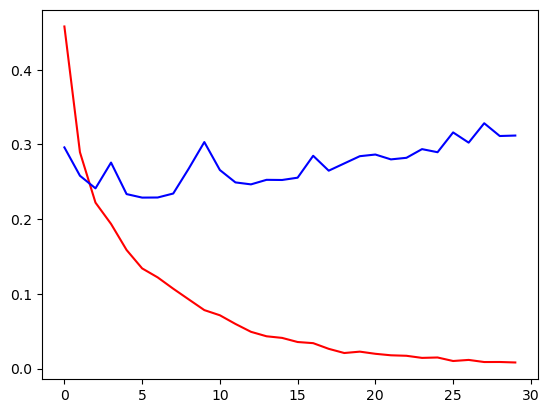

In [19]:
plt.plot(history.history['loss'], color='r')
plt.plot(history.history['val_loss'], color='b')

plt.show()

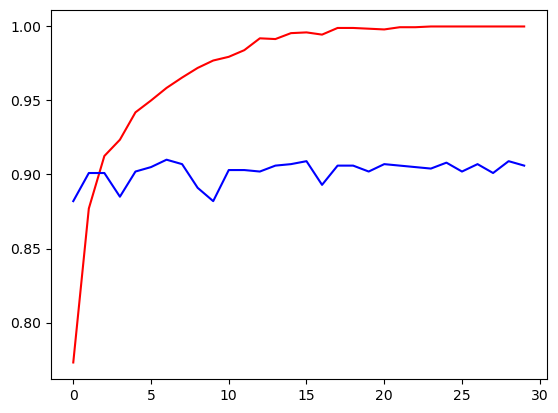

In [20]:
plt.plot(history.history['accuracy'], color='r')
plt.plot(history.history['val_accuracy'], color='b')

plt.show()